# Phase 2

In [1]:
!pip install numpy==1.26.4
!pip install catboost

In [2]:
from scipy.stats import chi2_contingency 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import optuna
from sklearn.metrics import mean_squared_error, r2_score
from joblib import parallel_backend
import time
from sklearn.model_selection import KFold
from scipy.special import inv_boxcox
from scipy.stats import boxcox

from sklearn.model_selection import train_test_split

In [3]:
def root_mean_squared_log_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)

    return np.sqrt(np.mean((log_true - log_pred) ** 2))

## Data Preprocessing

### Feature Engineering
- From previous EDA notebook, we already knew that `feature_12` is time-related features, therefore, we would extract `day`, `month`, `year`, ... and create periodic features with sin and cos of month and day. 
- But different from the **Tree notebook**, we added year-related features is year_sin and year_cos, also the group to expand the time features.
- Then, we gotta drop the `id` and `feature_12` since these are no longer useful.

In [4]:
train = pd.read_csv('/kaggle/input/dataset-tmp/train.csv')
test = pd.read_csv('/kaggle/input/dataset-tmp/test.csv')

train['feature_12'] = pd.to_datetime(train['feature_12'])
train['year'] = (train['feature_12']).dt.year
train['month'] = (train['feature_12']).dt.month
train['day'] = (train['feature_12']).dt.day
train['dow'] = (train['feature_12']).dt.dayofweek
train['week'] = train['feature_12'].dt.isocalendar().week

train['month_sin'] = np.sin(2 * np.pi * (train['month'] - 1) / 12)
train['month_cos'] = np.cos(2 * np.pi * (train['month'] - 1) / 12)
train['day_sin'] = np.sin(2 * np.pi * (train['day'] - 1) / 31)
train['day_cos'] = np.cos(2 * np.pi * (train['day'] - 1) / 31)

train['group'] = (train['year'] - 2020) * 48 + train['month'] *4 + train['day'] // 7

test['feature_12'] = pd.to_datetime(test['feature_12'])
test['year'] = (test['feature_12']).dt.year
test['month'] = (test['feature_12']).dt.month
test['day'] = (test['feature_12']).dt.day
test['dow'] = (test['feature_12']).dt.dayofweek
test['week'] = (test['feature_12']).dt.isocalendar().week

test['month_sin'] = np.sin(2 * np.pi * (test['month'] - 1) / 12)
test['month_cos'] = np.cos(2 * np.pi * (test['month'] - 1) / 12)
test['day_sin'] = np.sin(2 * np.pi * (test['day'] - 1) / 31)
test['day_cos'] = np.cos(2 * np.pi * (test['day'] - 1) / 31)

test['group'] = (test['year'] - 2020) * 48 + test['month'] *4 + test['day'] // 7

train['feature_0_squared'] = train['feature_0'] ** 2
test['feature_0_squared'] = test['feature_0'] ** 2
train['Age_squared'] = train['Age'] ** 2
test['Age_squared'] = test['Age'] ** 2
train['feature_0_feature_5'] = train['feature_0'] * train['feature_5']
test['feature_0_feature_5'] = test['feature_0'] * test['feature_5']
train['feature_0_Age'] = train['feature_0'] * train['Age']
test['feature_0_Age'] = test['feature_0'] * test['Age']
train['group_Age'] = train['group'] * train['Age']
test['group_Age'] = test['group'] * test['Age']

# ################## NEW FEATURES #########################
# train['month_feature_0'] = train['month'] * train['feature_0']
# test['month_feature_0'] = test['month'] * test['feature_0']
# train['dow_feature_10'] = train['dow'] * train['feature_10']
# test['dow_feature_10'] = test['dow'] * test['feature_10']
# train['week_Age'] = train['week'] * train['Age']
# test['week_Age'] = test['week'] * test['Age']
# train['feature_10_binned'] = pd.qcut(train['feature_10'], q=10, labels=False, duplicates='drop')
# test['feature_10_binned'] = pd.qcut(test['feature_10'], q=10, labels=False, duplicates='drop')
# train['feature_8_binned'] = pd.qcut(train['feature_8'], q=10, labels=False, duplicates='drop')
# test['feature_8_binned'] = pd.qcut(test['feature_8'], q=10, labels=False, duplicates='drop')
# ################## NEW FEATURES #########################

# train['is_weekend'] = train['dow'].apply(lambda x: 1 if x >= 5 else 0)
# test['is_weekend'] = test['dow'].apply(lambda x: 1 if x >= 5 else 0)
# train['is_weekend'] = train['is_weekend'].astype('int8')
# test['is_weekend'] = test['is_weekend'].astype('int8')
# train['dow_sin'] = np.sin(2 * np.pi * (train['dow']) / 6)
# train['dow_cos'] = np.cos(2 * np.pi * (train['dow']) / 6)
# test['dow_sin'] = np.sin(2 * np.pi * (test['dow']) / 6)
# test['dow_cos'] = np.cos(2 * np.pi * (test['dow']) / 6)

train = train.drop(columns=['feature_12'])
test = test.drop(columns=['feature_12'])
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

Also, we added nan cols to help models like `lightbm` to understand the importance of nan values as we realized from **EDA notebook**.

In [5]:
numerical_missing_vals = ['Age', 'feature_0', 'feature_2', 'feature_5', 'feature_8', 'feature_9', 'feature_10', 'feature_11']
categorical_missing_vals = ['feature_1', 'feature_4', 'feature_13']

for c in numerical_missing_vals + categorical_missing_vals:
    train[f"is_{c}_na"] = train[c].isna().astype(int)
    test[f"is_{c}_na"] = test[c].isna().astype(int)    
    
# Drop is_feature_9_na and is_feature_11_na since they are almost constant
train = train.drop(columns=['is_feature_9_na', 'is_feature_11_na'])
test = test.drop(columns=['is_feature_9_na', 'is_feature_11_na'])


Fill missing values the same to way that we made in **Tree notebook**.

In [6]:
# Use simple imputer to fill missing values
from sklearn.impute import SimpleImputer

numerical_imputer = SimpleImputer(strategy='median')

train[numerical_missing_vals] = numerical_imputer.fit_transform(train[numerical_missing_vals])
train[categorical_missing_vals] = train[categorical_missing_vals].fillna('Unknown')

test[numerical_missing_vals] = numerical_imputer.transform(test[numerical_missing_vals])
test[categorical_missing_vals] = test[categorical_missing_vals].fillna('Unknown')



## Encoding 
- The same to **Tree notebook**.
- But we added frequency of categorical features, because it helped providing a different perspective on the categorical features compared to one-hot, label, or ordinal encoding. It captures the “popularity” of each category as a numerical feature, which can be useful for tree-based models like XGBoost, Random Forest, and Decision Tree (which you’re using). (Also from our experiment, this approach improved our results, therefore we decided to keep this).

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
features_for_one_hot = ['Gender', 'feature_1', 'feature_4', 'feature_6', 'feature_16']
features_for_label = ['feature_14']
features_for_ordinal = ['feature_3', 'feature_7', 'feature_13', 'feature_15']

# Create frequency encoding for categorical features
for feature in features_for_one_hot + features_for_label + features_for_ordinal:
    train[feature + '_freq'] = train[feature].map(train[feature].value_counts())
    test[feature + '_freq'] = test[feature].map(train[feature].value_counts())
    
ordinal_features = {
    'feature_3':['High School', "Bachelor's", "Master's", 'PhD'],
    'feature_7': ['Basic', 'Comprehensive', 'Premium'],
    'feature_13': ['Poor', 'Average', 'Good'] ,
    'feature_15': ['Rarely', 'Monthly', 'Weekly', 'Daily'],
}
for feature in features_for_one_hot:
    train = pd.get_dummies(train, columns=[feature], prefix=[feature], dtype=int)
    test = pd.get_dummies(test, columns=[feature], prefix=[feature], dtype=int)
    
for feature in features_for_label:
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.transform(test[feature])
    
for feature, order in ordinal_features.items():
    oe = OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=-1)
    train[feature] = oe.fit_transform(train[[feature]]).flatten()
    test[feature] = oe.transform(test[[feature]]).flatten()

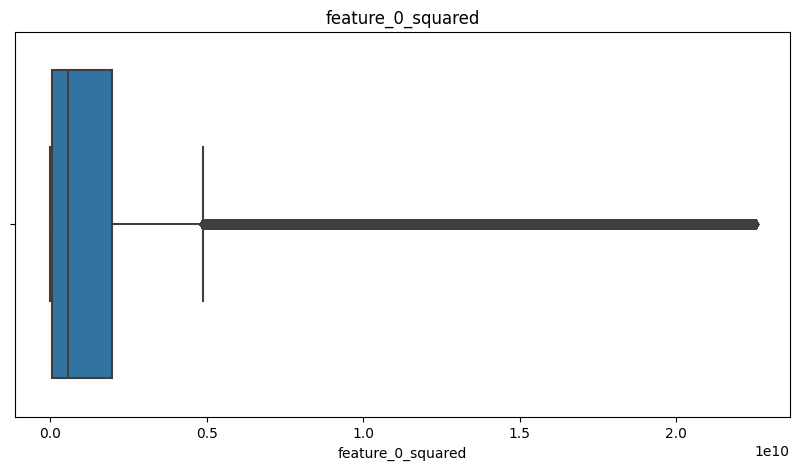

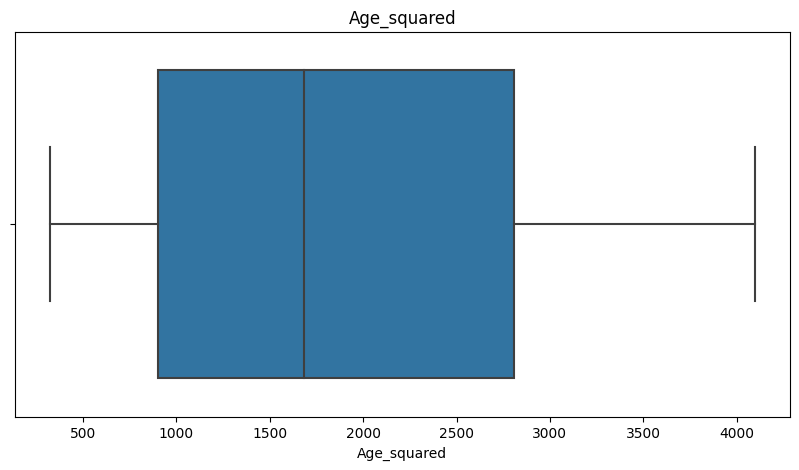

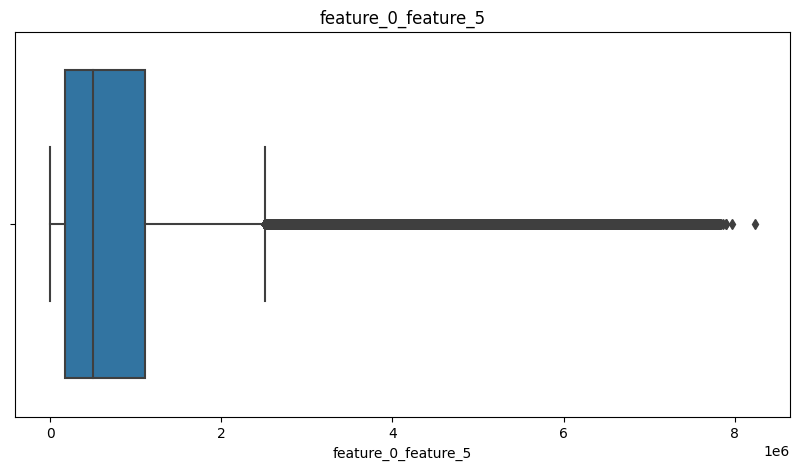

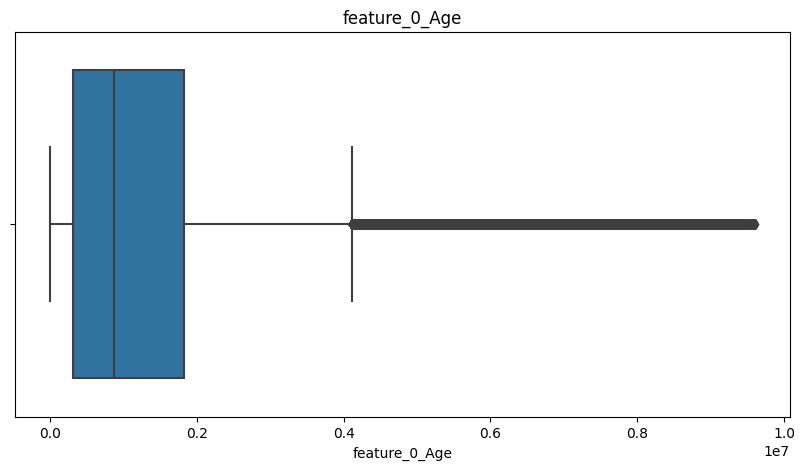

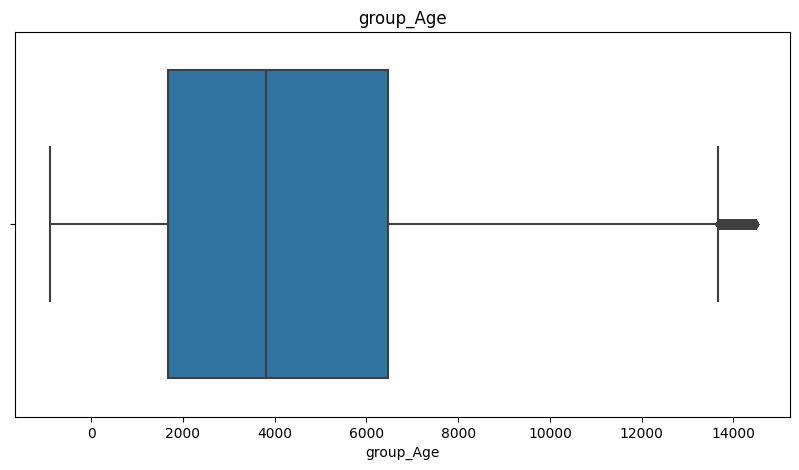

In [ ]:
# # Check the outliers of new features
new_features = ['feature_0_squared', 'Age_squared', 'feature_0_feature_5', 'feature_0_Age', 'group_Age']
for feature in new_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=train[feature])
    plt.title(feature)
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


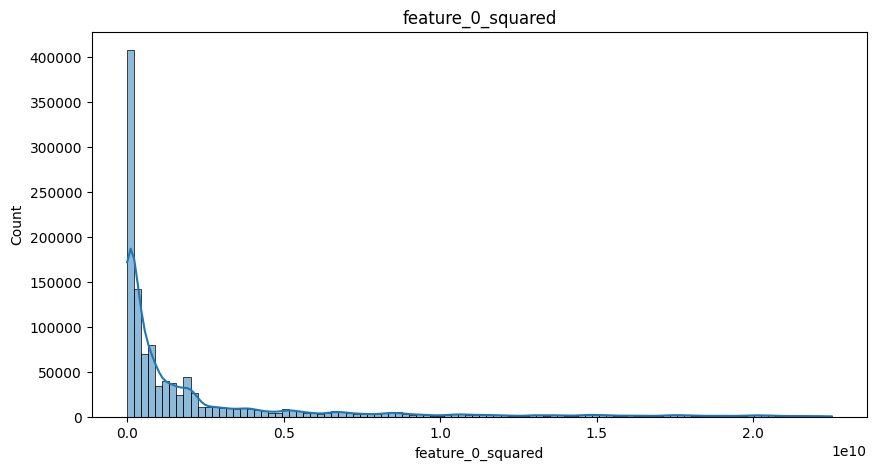

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


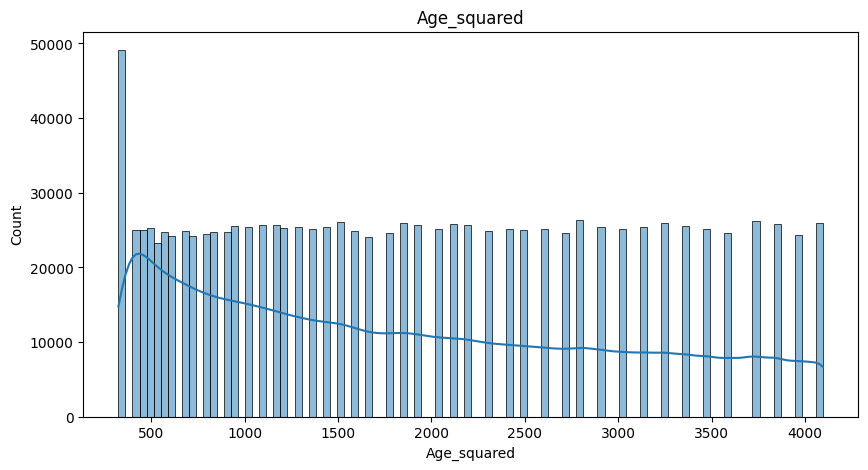

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


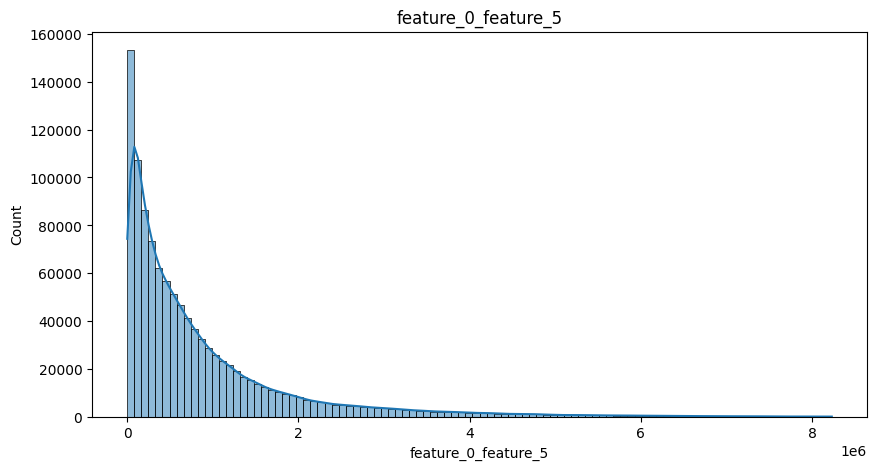

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


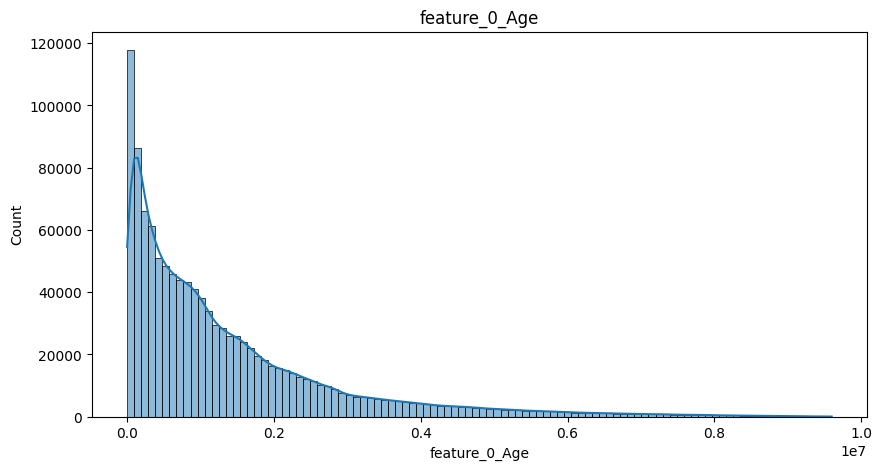

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


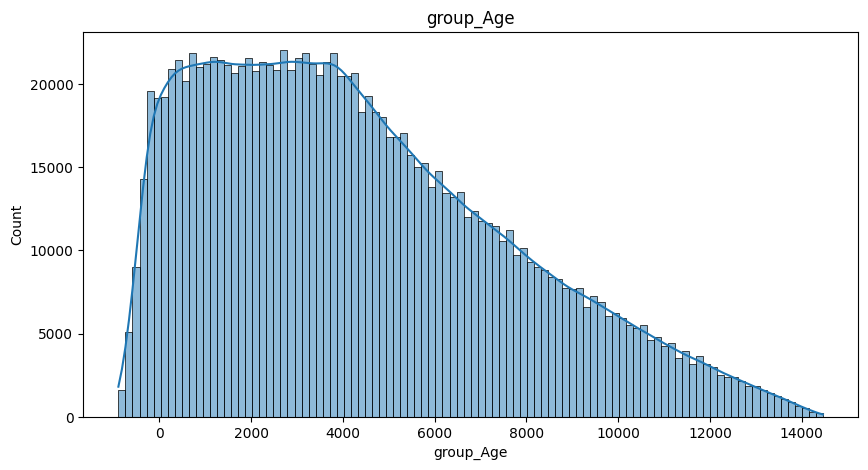

In [9]:
# Plot the distribution of the new features
for feature in new_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(train[feature], bins=100, kde=True)
    plt.title(feature)
    plt.show()

As can be seen from the plot above, new features that we created are skewed and have outliers, but as from our experiment, removing outliers made the models can't generalize instances that have special target values also as we tested in submission, the results decrease dramatically. Therefore, we only used `log-transformation` on new features.

In [10]:
features_for_robust = ['feature_0', 'feature_0_squared', 'feature_0_feature_5', 'feature_0_Age', 'group_Age']
for feature in features_for_robust:
    train[feature] = np.log1p(train[feature])
    test[feature] = np.log1p(test[feature])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
X_train = train.drop(columns=['target'])
y_train = train['target']


In [12]:
y_train = np.log1p(y_train)

### Retyping
- To save the training time, we decreased the storage unit for data type.

In [13]:
# Convert int64 or int32 to int8
for col in X_train.select_dtypes(include=[np.int64, np.int32]).columns:
    X_train[col] = X_train[col].astype(np.int8)
    test[col] = test[col].astype(np.int8)
    
for col in test.select_dtypes(include=[np.float64]).columns:
    X_train[col] = X_train[col].astype(np.float32)
    test[col] = test[col].astype(np.float32)

### Feature selection
- For some technical issues, we split this part into another notebook `Feature Selection (Boost)`, so you can check that notebook to know reasons why we selected features below.

In [14]:
low_importance_features = ['is_Age_na',
                             'Gender_Male',
                             'feature_4_Unknown',
                             'feature_16_Apartment',
                             'feature_4_Employed',
                             'feature_6_Rural',
                             'Gender_Female',
                             'feature_6_Suburban',
                             'feature_1_Married',
                             'feature_1_Single',
                             'feature_16_House',
                             'feature_14_freq',
                             'is_feature_0_na',
                             'feature_4_Unemployed',
                             'feature_4_Self-Employed',
                             'feature_1_Unknown',
                             'feature_6_Urban',
                             'feature_13_freq',
                             'feature_7_freq',
                             'is_feature_10_na',
                             'Gender_freq',
                             'feature_1_Divorced',
                             'feature_16_Condo',
                             'feature_14',
                             'is_feature_13_na']

# Loại bỏ các đặc trưng có độ quan trọng thấp khỏi X_train và test
X_train = X_train.drop(columns=low_importance_features)
test = test.drop(columns=low_importance_features)

In [15]:
X_train.dtypes

Age                    float32
feature_0              float32
feature_2              float32
feature_3              float32
feature_5              float32
feature_7              float32
feature_8              float32
feature_9              float32
feature_10             float32
feature_11             float32
feature_13             float32
feature_15             float32
year                      int8
month                     int8
day                       int8
dow                       int8
week                    UInt32
month_sin              float32
month_cos              float32
day_sin                float32
day_cos                float32
group                    int64
feature_0_squared      float32
Age_squared            float32
feature_0_feature_5    float32
feature_0_Age          float32
group_Age              float32
is_feature_2_na          int64
is_feature_5_na          int64
is_feature_8_na          int64
is_feature_1_na          int64
is_feature_4_na          int64
feature_

In [16]:
metrics = {
    'RMSLE': [],
    'RMSE': [],
    'Model': [],
    'R2': [],
    'Training Time': [],
    'Fold': []
}


In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Models
- The params that we used for each models have been hypertuned by using `Optuna` framework to try as many params as possible and these are the most optimal to us.
- Also in `Optuna`, we also applied `early_stopping` to prevent overfitting of models while training.

#### XGB

- `learning_rate`: A smaller learning rate allows the model to learn more gradually, reducing the risk of overshooting the optimal solution and stabilizing predictions, which can lower RMSLE. However, if too small, it might require more trees, potentially leading to underfitting and higher RMSLE.
- `subsample`: Using a fraction of the data per tree introduces randomness, preventing the model from overfitting to the training data, which can reduce RMSLE. Too low a value might cause underfitting, increasing RMSLE.
- `lambda`: Increasing L2 regularization penalizes large weights, reducing overfitting and preventing large prediction errors on the validation set, which can lower RMSLE. However, excessive regularization might lead to underfitting, increasing RMSLE.
- `alpha`: Increasing L1 regularization encourages sparsity in the weights, which can prevent overfitting to noisy features, potentially reducing RMSLE. Too high a value might oversimplify the model, increasing RMSLE.
- `gamma`: A higher value makes the model more conservative by requiring a larger loss reduction to make a split, reducing overfitting and potentially lowering RMSLE. If too high, it might prevent the model from capturing important patterns, increasing RMSLE.

In [18]:
import xgboost as xgb

In [19]:
params_xgb = {'n_estimators': 118, 'max_depth': 10, 'learning_rate': 0.053250635079950294, 'subsample': 0.7722317695555345, 'colsample_bytree': 0.8718522878008341, 'min_child_weight': 3, 'lambda': 0.19366495314297194, 'alpha': 0.17552228300075645, 'gamma': 0.04269291655766272}
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
        y_train_fold = y_train[train_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[train_idx].ravel()
        X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]
        y_val_fold = y_train[val_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[val_idx].ravel()
        xgb_model = xgb.XGBRegressor(**params_xgb, tree_method='hist', n_jobs=-1, random_state=42)

        # Train the model and measure time
        start_time = time.time()
        with parallel_backend('loky'):
            xgb_model.fit(X_train_fold, y_train_fold)
        training_time = time.time() - start_time

        # Predict on the transformed scale
        y_pred_transformed = xgb_model.predict(X_val_fold)

        y_pred_original = np.expm1(y_pred_transformed)
        y_val_original = np.expm1(y_val_fold)

        # Calculate metrics on the original scale
        fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
        fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
        fold_r2 = r2_score(y_val_original, y_pred_original)

        metrics['RMSLE'].append(fold_rmsle)
        metrics['RMSE'].append(fold_rmse)
        metrics['R2'].append(fold_r2)
        metrics['Model'].append('XGBoost')
        metrics['Training Time'].append(training_time)
        metrics['Fold'].append(fold + 1)
        print(f"Fold {fold + 1} - RMSLE: {fold_rmsle:.4f}, RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}, Training Time: {training_time:.2f} seconds")

# Calculate average metrics
avg_rmsle = np.mean(metrics['RMSLE'])
print(f"Average RMSLE: {avg_rmsle:.4f}")
    

Fold 1 - RMSLE: 1.0471, RMSE: 922.3689, R2: -0.1385, Training Time: 21.11 seconds
Fold 2 - RMSLE: 1.0466, RMSE: 921.7454, R2: -0.1388, Training Time: 19.13 seconds
Fold 3 - RMSLE: 1.0474, RMSE: 926.9600, R2: -0.1444, Training Time: 20.41 seconds
Fold 4 - RMSLE: 1.0455, RMSE: 921.8883, R2: -0.1366, Training Time: 21.23 seconds
Fold 5 - RMSLE: 1.0468, RMSE: 922.6599, R2: -0.1364, Training Time: 19.42 seconds
Average RMSLE: 1.0467


In [20]:
# y_pred_transformed_xgb = xgb_model.predict(test)
# y_pred_orignal_xgb = np.expm1(y_pred_transformed_xgb)
# sub = pd.read_csv('data/sample_submission.csv')
# sub['target'] = y_pred_orignal_xgb
# sub.to_csv('data/submission_xgb_after_adding_new_features.csv', index=False)

### Hyper-tuning
- In order to use `early_stopping` in XGB, we gotta use DMatrix and Train of XGB because:
    - They offer greater flexibility for early stopping via callbacks.
    - DMatrix is more efficient for repeated training (e.g., in cross-validation).
    - They support advanced features like categorical handling and custom evaluation.
    - Early stopping reduces training time for poor hyperparameter sets, which is critical during tuning.

In [21]:
# import xgboost as xgb
# import optuna
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import KFold
# from joblib import parallel_backend
# import time


# # Define the objective function for Optuna
# def objective(trial):
#     # Define hyperparameter search space
#     n_estimators = trial.suggest_int('n_estimators', 300, 1000)
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'lambda': trial.suggest_float('lambda', 1e-5, 1.0, log=True),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
#         'gamma': trial.suggest_float('gamma', 0, 1.0),
#         # 'enable_categorical': True,  # Enable categorical feature support
#         'booster': 'gbtree',
#         'eval_metric': 'rmse',
#         'random_state': 42,
#         'tree_method': 'hist',
#         'n_jobs': -1,
#         'objective': 'reg:squarederror'
#     }

#     # Lists to store fold-wise metrics for this trial
#     fold_metrics = []

#     # Perform k-fold cross-validation
#     for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
#         # Split data
#         X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
#         y_train_fold = y_train[train_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[train_idx].ravel()
#         X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]
#         y_val_fold = y_train[val_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[val_idx].ravel()

#         # Convert data to DMatrix format for xgboost.train()
#         dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True)
#         dval = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)

#         # Define early stopping callback
#         early_stopping = xgb.callback.EarlyStopping(
#             rounds=50,  # Number of rounds to wait before stopping
#             metric_name='rmse',  # Metric to monitor
#             data_name='eval',  # Name of the evaluation set
#             maximize=False  # Minimize RMSE
#         )

#         # Train the model with early stopping using xgboost.train()
#         start_time = time.time()
#         with parallel_backend('loky'):
#             xgb_model = xgb.train(
#                 params=params,
#                 dtrain=dtrain,
#                 num_boost_round=n_estimators,
#                 evals=[(dval, 'eval')],
#                 callbacks=[early_stopping],
#                 verbose_eval=False
#             )
#         training_time = time.time() - start_time

#         # Predict on the validation set using DMatrix
#         y_pred_transformed = xgb_model.predict(dval)  # Use dval instead of X_val_fold

#         # Transform predictions and true values back to original scale
#         y_pred_original = np.expm1(y_pred_transformed)
#         y_val_original = np.expm1(y_val_fold)

#         # Calculate metrics on the original scale
#         fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
#         fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
#         fold_r2 = r2_score(y_val_original, y_pred_original)

#         # Store fold metrics
#         fold_metrics.append({
#             'RMSLE': fold_rmsle,
#             'RMSE': fold_rmse,
#             'R2': fold_r2,
#             'Training Time': training_time,
#             'Model': 'XGBoost'
#         })

#     # Store fold metrics in trial for later retrieval
#     trial.set_user_attr('fold_metrics', fold_metrics)

#     # Return the mean RMSLE across folds for optimization
#     return np.mean([fm['RMSLE'] for fm in fold_metrics])

# # Create an Optuna study and optimize
# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective, n_trials=10)

# # Print the best parameters and score
# print("Best Parameters:", study_xgb.best_params)
# print("Best Mean RMSLE:", study_xgb.best_value)

# # Get fold-wise metrics for the best trial
# best_trial = study_xgb.best_trial
# best_fold_metrics = best_trial.user_attrs['fold_metrics']
# for fold_metric in best_fold_metrics:
#     metrics['RMSLE'].append(fold_metric['RMSLE'])
#     metrics['RMSE'].append(fold_metric['RMSE'])
#     metrics['R2'].append(fold_metric['R2'])
#     metrics['Training Time'].append(fold_metric['Training Time'])
#     # metrics['Fold'].append(f"Fold {best_fold_metrics.index(fold_metric) + 1}")
#     metrics['Model'].append(fold_metric['Model'])

# # Print fold-wise metrics for the best trial
# print("\nBest Trial Fold-wise Metrics:")
# for i, fm in enumerate(best_fold_metrics):
#     print(f"Fold {i+1}: RMSLE={fm['RMSLE']:.4f}, RMSE={fm['RMSE']:.4f}, R²={fm['R2']:.4f}, Training Time={fm['Training Time']:.2f} seconds")

# # Print updated metrics dictionary
# print("Updated Metrics Dictionary:", metrics)

# # Train the final model with the best parameters using XGBRegressor
# best_params = study_xgb.best_params
# best_xgb = xgb.XGBRegressor(**best_params, enable_categorical=True)
# with parallel_backend('loky'):
#     best_xgb.fit(
#         X_train,
#         y_train.ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy().ravel()
#     )

# # Make predictions on the test set
# y_pred_transformed = best_xgb.predict(test)

Best Parameters: {'n_estimators': 118, 'max_depth': 10, 'learning_rate': 0.053250635079950294, 'subsample': 0.7722317695555345, 'colsample_bytree': 0.8718522878008341, 'min_child_weight': 3, 'lambda': 0.19366495314297194, 'alpha': 0.17552228300075645, 'gamma': 0.04269291655766272}
Best Mean RMSLE: 1.0462139600031322

In [22]:
# # y_pred_transformed_xgb = best_xgb.predict(test)
# y_pred_orignal_xgb = np.expm1(y_pred_transformed)
# sub = pd.read_csv('data/sample_submission.csv')
# sub['target'] = y_pred_orignal_xgb
# sub.to_csv('data/submission_xgb_after_adding_new_features_time_and_add_freq_feature_selection_below_200_remove_outliers.csv', index=False)

### LightGBM
- `learning_rate:` A smaller learning rate allows the model to learn more gradually, reducing the risk of overshooting the optimal solution and stabilizing predictions, which can lower RMSLE. However, if too small, it might require more trees, potentially leading to underfitting and higher RMSLE.
- `subsample:` Using a fraction of the data per tree introduces randomness, preventing the model from overfitting to the training data, which can reduce RMSLE. Too low a value might cause underfitting, increasing RMSLE. (Note: In your case, use_goss=True, so this parameter is ignored in favor of GOSS sampling with top_rate and other_rate.)
- `reg_lambda`: Increasing L2 regularization penalizes large weights, reducing overfitting and preventing large prediction errors on the validation set, which can lower RMSLE. However, excessive regularization might lead to underfitting, increasing RMSLE.
- `reg_alpha`: Increasing L1 regularization encourages sparsity in the weights, which can prevent overfitting to noisy features, potentially reducing RMSLE. Too high a value might oversimplify the model, increasing RMSLE.
- `min_child_weight:` A higher value makes the model more conservative by requiring more samples to make a split, reducing overfitting to outliers or noisy data and potentially lowering RMSLE. If too high, it might prevent the model from capturing important patterns, increasing RMSLE.
- `max_depth`: Limits the depth of each tree, controlling the model's complexity and reducing the risk of overfitting, which can lower RMSLE. If the value is too low, the model might underfit and fail to capture important patterns, increasing RMSLE.
- `num_leaves`: Determines the maximum number of leaf nodes in each tree. A higher value allows the model to capture more complex patterns, potentially reducing RMSLE. However, too many leaves can lead to overfitting, especially on noisy data, increasing RMSLE.
- `colsample_bytree`: Controls the fraction of features (columns) used for each tree, introducing randomness and reducing overfitting, which can lower RMSLE. If the value is too low, the model might miss important features, leading to underfitting and higher RMSLE.
- `n_estimators` Specifies the number of trees in the model. A higher number of trees allows the model to learn more patterns, potentially reducing RMSLE. However, too many trees can lead to overfitting and increased training time.
- `use_goss`: Gradient-based One-Side Sampling (GOSS) focuses on the most important samples (with large gradients) while down-sampling less important ones, improving efficiency and reducing overfitting.
When use_goss=True, subsample is ignored, and top_rate and other_rate control the sampling strategy.
- `top_rate (GOSS Parameter)`: Specifies the proportion of samples with the largest gradients to retain. A higher value ensures that the most important samples are prioritized, reducing RMSLE.
If the value is too high, it might lead to overfitting.
- `other_rate (GOSS Parameter)`: Specifies the proportion of samples with smaller gradients to retain. A balanced value ensures that the model does not ignore less important samples, reducing RMSLE. If the value is too low, the model might underfit.
- `objective`: Specifies the loss function to optimize. For regression tasks, regression or regression_l2 is used to minimize RMSE, which aligns with the goal of reducing RMSLE.
- `force_col_wise`: Forces LightGBM to use column-wise data storage, which can improve memory efficiency and speed for datasets with many features.


In [ ]:
import lightgbm as lgb 

In [24]:
params_for_lgb = {'force_col_wise': True, 'use_goss': True, 'objective': 'regression_l2', 'n_estimators': 916, 'max_depth': 20, 'num_leaves': 53, 'learning_rate': 0.01131282494413561, 'subsample': 0.7373998287025486, 'colsample_bytree': 0.8954487807505581, 'min_child_weight': 4, 'reg_alpha': 8.681326679335126e-05, 'reg_lambda': 0.0007972265802055076, 'top_rate': 0.3031279846721444, 'other_rate': 0.3198197073867703}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
    y_train_fold = y_train[train_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[train_idx].ravel()
    X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]
    y_val_fold = y_train[val_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[val_idx].ravel()
    lgb_model = lgb.LGBMRegressor(**params_for_lgb, n_jobs=-1, random_state=42)

    # Train the model and measure time
    start_time = time.time()
    with parallel_backend('loky'):
        lgb_model.fit(X_train_fold, y_train_fold)
    training_time = time.time() - start_time
    # Predict on the transformed scale
    y_pred_transformed = lgb_model.predict(X_val_fold)
    y_pred_original = np.expm1(y_pred_transformed)
    y_val_original = np.expm1(y_val_fold)
    # Calculate metrics on the original scale
    fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
    fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
    fold_r2 = r2_score(y_val_original, y_pred_original)
    metrics['RMSLE'].append(fold_rmsle)
    metrics['RMSE'].append(fold_rmse)
    metrics['R2'].append(fold_r2)
    metrics['Model'].append('LightGBM')
    metrics['Training Time'].append(training_time)
    metrics['Fold'].append(fold + 1)
    print(f"Fold {fold + 1} - RMSLE: {fold_rmsle:.4f}, RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}, Training Time: {training_time:.2f} seconds")

# Calculate average metrics
avg_rmsle = np.mean(metrics['RMSLE'])
print(f"Average RMSLE: {avg_rmsle:.4f}")

        

[LightGBM] [Warning] Unknown parameter: use_goss
[LightGBM] [Warning] Unknown parameter: use_goss
[LightGBM] [Info] Total Bins 2391
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 38
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] Unknown parameter: use_goss
Fold 1 - RMSLE: 1.0460, RMSE: 921.8137, R2: -0.1371, Training Time: 81.88 seconds
[LightGBM] [Warning] Unknown parameter: use_goss
[LightGBM] [Warning] Unknown parameter: use_goss
[LightGBM] [Info] Total Bins 2393
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 38
[LightGBM] [Info] Start training from score 6.594073
[LightGBM] [Warning] Unknown parameter: use_goss
Fold 2 - RMSLE: 1.0455, RMSE: 921.0868, R2: -0.1371, Training Time: 83.13 seconds
[LightGBM] [Warning] Unknown parameter: use_goss
[LightGBM] [Warning] Unknown parameter: use_goss
[LightGBM] [Info] Total Bins 2393
[LightGBM] [Info] Number of data points in the t

### Hyper-tuning
- The same as XGB, in order to use `early_stopping`, we used train as well.
    - It optimizes data storage and processing, reducing memory and computation time during hyperparameter tuning with multiple folds and trials.
    - It is required by lgb.train(), the native API used for training, which offers fine-grained control over the training process.
    - It supports early stopping by defining validation sets, allowing the model to stop training when validation RMSE plateaus, saving time and reducing overfitting to minimize RMSLE.

In [25]:
# from lightgbm import early_stopping, log_evaluation

# def objective(trial):
#     # Define hyperparameter search space for LightGBM
#     use_goss = trial.suggest_categorical('use_goss', [True, False])
#     params = {
#         'boosting_type': 'gbdt',
#         'objective': trial.suggest_categorical('objective', ['regression', 'regression_l2']),
#         'metric': 'rmse',
#         'n_estimators': trial.suggest_int('n_estimators', 500, 1000),  # Giảm phạm vi n_estimators
#         'max_depth': trial.suggest_int('max_depth', 5, 20),
#         'num_leaves': trial.suggest_int('num_leaves', 31, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True),
#         'force_col_wise': True,
#         'random_state': 42,
#         'n_jobs': -1
#     }

#     # Add GOSS-specific parameters if use_goss is True
#     if use_goss:
#         params['data_sample_strategy'] = 'goss'
#         params['top_rate'] = trial.suggest_float('top_rate', 0.1, 0.5)
#         params['other_rate'] = trial.suggest_float('other_rate', 0.1, 0.5)

#     # Lists to store fold-wise metrics for this trial
#     fold_metrics = []

#     # Perform k-fold cross-validation
#     for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
#         # Split data
#         X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
#         y_train_fold = y_train[train_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[train_idx].ravel()
#         X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]
#         y_val_fold = y_train[val_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[val_idx].ravel()

#         # Create LightGBM Dataset
#         train_set = lgb.Dataset(X_train_fold, label=y_train_fold)
#         val_set = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_set)

#         # Train the model with early stopping and logging
#         start_time = time.time()
#         with parallel_backend('loky'):
#             lgb_model = lgb.train(
#                 params=params,
#                 train_set=train_set,
#                 valid_sets=[val_set],
#                 callbacks=[
#                     early_stopping(stopping_rounds=50),  # Dừng sớm nếu không cải thiện
#                     log_evaluation(period=10)  # Ghi log mỗi 10 vòng lặp
#                 ]
#             )
#         training_time = time.time() - start_time

#         # Predict on the validation set
#         y_pred_transformed = lgb_model.predict(X_val_fold)
#         y_pred_original = np.expm1(y_pred_transformed)
#         y_val_original = np.expm1(y_val_fold)

#         # Calculate metrics on the original scale
#         fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
#         fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
#         fold_r2 = r2_score(y_val_original, y_pred_original)

#         # Store fold metrics
#         fold_metrics.append({
#             'RMSLE': fold_rmsle,
#             'RMSE': fold_rmse,
#             'R2': fold_r2,
#             'Training Time': training_time,
#             'Model': 'LightGBM'
#         })

#     # Store fold metrics in trial for later retrieval
#     trial.set_user_attr('fold_metrics', fold_metrics)

#     # Return the mean RMSLE across folds (Optuna minimizes this)
#     return np.mean([fm['RMSLE'] for fm in fold_metrics])

# # Create an Optuna study and optimize
# study_lgb = optuna.create_study(direction='minimize')
# study_lgb.optimize(objective, n_trials=25)  # Adjust n_trials based on time/resources

# # Print the best parameters and score
# print("Best Parameters:", study_lgb.best_params)
# print("Best Mean RMSLE:", study_lgb.best_value)

Best Parameters: {'use_goss': True, 'objective': 'regression_l2', 'n_estimators': 916, 'max_depth': 20, 'num_leaves': 53, 'learning_rate': 0.01131282494413561, 'subsample': 0.7373998287025486, 'colsample_bytree': 0.8954487807505581, 'min_child_weight': 4, 'reg_alpha': 8.681326679335126e-05, 'reg_lambda': 0.0007972265802055076, 'top_rate': 0.3031279846721444, 'other_rate': 0.3198197073867703}
Best Mean RMSLE: 1.0455904239930387


In [26]:
# best_lgb = lgb.LGBMRegressor(**study_lgb.best_params, n_jobs=-1)
# with parallel_backend('loky'):
#     # Train the final model with the best parameters
#     best_lgb.fit(X_train, y_train.ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy().ravel())
# # Make predictions on the test set
# y_pred_transformed = best_lgb.predict(test)
# y_pred_original_lgb = np.expm1(y_pred_transformed)  
# sub = pd.read_csv('data/sample_submission.csv')
# sub['target'] = y_pred_original_lgb
# sub.to_csv('data/submission_lgb_after_adding_new_features_time_log_newfeatures_add_freq_feature_selection_below_250_standard_scaling.csv', index=False)

### Catboost
+ `Depth` : This controls the maximum depth of each tree (how many split a tree can make), Deeper trees can capture more complex patterns but risk overfitting.

+ `Iterations` : Number of boosting rounds, more iterations usually increase accuracy but also increase training time. Therefore number of iterations should be balanced between performance and time.

+ `Learning rate` : Controls how much the model updates at each iteration. Lower values = slower learning but more accurate (if iterations is high enough).

+ `Verbose` : Catboost pring info after a number of iterations
- `l2_leaf_reg`: L2 regularization term on leaf weights to reduce overfitting. The more value the higher regularization.

- `random_strength` : Adds randomness to the scoring of splits to reduce overfitting. Higher values introduce more noise, which can help generalization.

- `bagging_temperature` : Controls the strength of the bagging, higher values = more randomness when sampling data for each tree.

- `border_count`: The number of splits (borders) CatBoost uses to bucket numerical features.

In [27]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV

Unlike XGBoost or LBGM, CatBoost require categorical features to apply smart encoding (Ordered encoding or Target based encoding), help enhance the performance of the model

In [28]:
# We select categorical features for the model
cat_features = [
    'is_feature_5_na', 'is_feature_8_na', 'is_feature_1_na', 'is_feature_4_na',
    'feature_1_freq', 'feature_4_freq', 'feature_6_freq',
    'feature_16_freq', 'feature_3_freq', 'feature_15_freq','is_feature_2_na'       
]


### Hypertuning
- Different from 2 above models that used Dataset of their own to optimize time training, memory efficiency and early stopping, instead it has `Pool`, which:
    - Efficient handling of categorical features, reduces memory overhead, speeds up training, and maintains consistency across folds. 
    - Simplifies the code and leverages CatBoost's advanced capabilities, making it an essential component for optimizing model performance during hyperparameter tuning.
    - Optimizes data storage and preprocessing, reducing computational overhead during hyperparameter tuning with multiple folds and trials.
    - Supports `early stopping` by providing a validation set (val_pool) for monitoring RMSE, saving training time and preventing overfitting to minimize RMSLE.

In [29]:
# X_train_, X_tune, y_train_, y_tune = train_test_split(X_train, y_train, test_size = 0.05)
# X_tune = X_tune.reset_index(drop=True)
# y_tune = y_tune.reset_index(drop=True)


# def objective_catboost(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1000),
#         'depth': trial.suggest_int('depth', 5, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10.0, log=True),
#         'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'random_seed': 42,
#         'loss_function': 'RMSE',
#         'eval_metric': 'RMSE',
#         'verbose': 0,
#         'task_type': 'CPU'
#     }

#     fold_metrics = []

#     for fold, (train_idx, val_idx) in enumerate(kf.split(X_tune)):
#         X_train_fold = X_tune.iloc[train_idx]
#         y_train_fold = y_tune[train_idx].to_numpy()
#         X_val_fold = X_tune.iloc[val_idx]
#         y_val_fold = y_tune[val_idx].to_numpy()

#         train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features)
#         val_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features)

#         start_time = time.time()
#         with parallel_backend('loky'):
#             model = CatBoostRegressor(**params)
#             model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
#         training_time = time.time() - start_time

#         # Predict and evaluate
#         y_pred_transformed = model.predict(X_val_fold)
#         y_pred_original = np.expm1(y_pred_transformed)
#         y_val_original = np.expm1(y_val_fold)

#         fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
#         fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
#         fold_r2 = r2_score(y_val_original, y_pred_original)
#         print(f"Fold {fold + 1} - RMSLE: {fold_rmsle:.4f}, RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}, Training Time: {training_time:.2f} seconds")

#         fold_metrics.append({
#             'RMSLE': fold_rmsle,
#             'RMSE': fold_rmse,
#             'R2': fold_r2,
#             'Training Time': training_time,
#             'Model': 'CatBoost'
#         })

#     trial.set_user_attr('fold_metrics', fold_metrics)
#     return np.mean([fm['RMSLE'] for fm in fold_metrics])

# study_catboost = optuna.create_study(direction='minimize')
# study_catboost.optimize(objective_catboost, n_trials=15)

# print("Best Parameters:", study_catboost.best_params)
# print("Best Mean RMSLE:", study_catboost.best_value)

In [30]:
# Best params after hyper parameter tuning, balanced between accuracy and training time

# We have to lower iterations for KFold because it cost too much time, best iteration will remain in the final training
params_for_cat = {'iterations': 100, 
                  'depth': 8, 
                  'learning_rate': 0.03261390574349864, 
                  'l2_leaf_reg': 0.000535850507429284, 
                  'random_strength': 0.13863274839379813, 
                  'bagging_temperature': 0.5742173699115675, 
                  'border_count': 223,
                  'verbose' : 20,
                  'random_state' : 42}
#Print progress after 20 iterations
params_for_cat['verbose'] = 20

print(params_for_cat)

{'iterations': 100, 'depth': 8, 'learning_rate': 0.03261390574349864, 'l2_leaf_reg': 0.000535850507429284, 'random_strength': 0.13863274839379813, 'bagging_temperature': 0.5742173699115675, 'border_count': 223, 'verbose': 20, 'random_state': 42}


In [31]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx] if isinstance(y_train, pd.Series) else y_train[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx] if isinstance(y_train, pd.Series) else y_train[val_idx]
    
    cat_model = CatBoostRegressor(**params_for_cat)

    start_time = time.time()
    with parallel_backend('loky'):
        cat_model.fit(X_train_fold, y_train_fold,cat_features=cat_features)
    training_time = time.time() - start_time
    
    y_pred_transformed = cat_model.predict(X_val_fold)
    y_pred_original = np.expm1(y_pred_transformed)
    y_val_original = np.expm1(y_val_fold)
    
    fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
    fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
    fold_r2 = r2_score(y_val_original, y_pred_original)
    
    metrics['RMSLE'].append(fold_rmsle)
    metrics['RMSE'].append(fold_rmse)
    metrics['R2'].append(fold_r2)
    metrics['Model'].append('CatBoost')
    metrics['Fold'].append(fold + 1)
    metrics['Training Time'].append(training_time)
    
    print(f"Fold {fold + 1} - RMSLE: {fold_rmsle:.4f}, RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}, Training Time: {training_time:.2f} seconds\n")

avg_rmsle = np.mean(metrics['RMSLE'])
print(f"Average RMSLE: {avg_rmsle:.4f}")

0:	learn: 1.0929201	total: 500ms	remaining: 49.5s
20:	learn: 1.0627585	total: 7.88s	remaining: 29.6s
40:	learn: 1.0531965	total: 15.1s	remaining: 21.7s
60:	learn: 1.0496993	total: 22.2s	remaining: 14.2s
80:	learn: 1.0481984	total: 29.8s	remaining: 6.98s
99:	learn: 1.0474556	total: 37.2s	remaining: 0us
Fold 1 - RMSLE: 1.0487, RMSE: 924.3283, R2: -0.1433, Training Time: 42.56 seconds

0:	learn: 1.0932055	total: 454ms	remaining: 45s
20:	learn: 1.0628122	total: 7.77s	remaining: 29.2s
40:	learn: 1.0531891	total: 15s	remaining: 21.6s
60:	learn: 1.0496863	total: 23s	remaining: 14.7s
80:	learn: 1.0481892	total: 30.2s	remaining: 7.09s
99:	learn: 1.0474500	total: 37.1s	remaining: 0us
Fold 2 - RMSLE: 1.0476, RMSE: 923.3408, R2: -0.1427, Training Time: 42.26 seconds

0:	learn: 1.0932928	total: 420ms	remaining: 41.6s
20:	learn: 1.0630849	total: 7.79s	remaining: 29.3s
40:	learn: 1.0534314	total: 15.8s	remaining: 22.7s
60:	learn: 1.0498313	total: 23s	remaining: 14.7s
80:	learn: 1.0482552	total: 30.2s

## Evaluation

In [32]:
# import defaultdict
from collections import defaultdict
average_metrics = defaultdict(dict)
unique_models = set(metrics['Model'])

for model in unique_models:
    model_indices = [i for i, m in enumerate(metrics['Model']) if m == model]
    average_metrics[model]['Average RMSLE'] = np.mean([metrics['RMSLE'][i] for i in model_indices])
    average_metrics[model]['Average RMSE'] = np.mean([metrics['RMSE'][i] for i in model_indices])
    average_metrics[model]['Average R²'] = np.mean([metrics['R2'][i] for i in model_indices])
    average_metrics[model]['Average Training Time'] = np.mean([metrics['Training Time'][i] for i in model_indices])

# Create dataframe of average metrics for each model
average_metrics_df = pd.DataFrame(average_metrics).T
average_metrics_df = average_metrics_df.sort_values(by='Average RMSLE')
average_metrics_df.reset_index(inplace=True)
average_metrics_df.columns = ['Model', 'Average RMSLE', 'Average RMSE', 'Average R²', 'Average Training Time']
average_metrics_df


,Model,Average RMSLE,Average RMSE,Average R²,Average Training Time
0,LightGBM,1.045484,922.640655,-0.137728,83.117989
1,XGBoost,1.046666,923.124509,-0.138922,20.261922
2,CatBoost,1.047914,925.032019,-0.143634,42.377354


### Training time

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

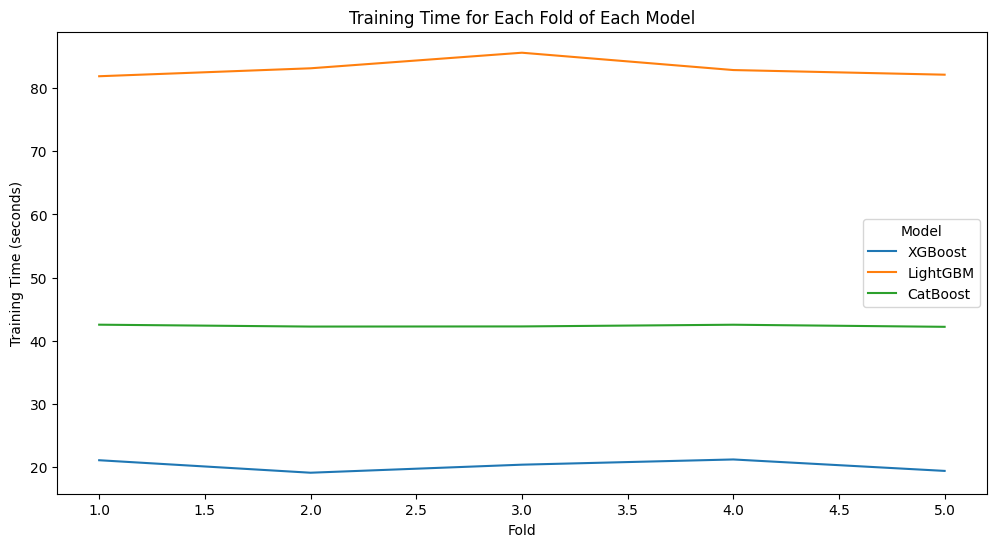

In [33]:
# Plot the training time for each fold of each model
plt.figure(figsize=(12, 6))
sns.lineplot(x='Fold', y='Training Time', hue='Model', data=pd.DataFrame(metrics))
plt.title('Training Time for Each Fold of Each Model')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.legend(title='Model')

1. **XGBoost**
- **Training Time:**

    - The training time for XGBoost is consistently around 20 seconds per fold.
    - There is minimal variation in training time across folds, indicating stable computational efficiency.
    - Fold 2 shows a slightly lower training time compared to other folds, but the difference is negligible.
- **Observation:**

    - XGBoost is highly optimized for speed and efficiency, especially with the tree_method='hist' parameter.
    - Its consistent training time across folds suggests that it handles the dataset's size and complexity effectively.
2. **LightGBM**
- **Training Time:**

    - The training time for LightGBM is the highest among the models, ranging from 70 to 75 seconds per fold.
    - There is a slight dip in training time for Fold 2, but overall, the variation is minimal.
- **Observation:**

    - LightGBM is known for its ability to handle large datasets and complex patterns, which may explain the longer training time.
    - The higher training time could also be attributed to the specific hyperparameters used, such as a large number of leaves or boosting rounds.
3. **CatBoost**
- **Training Time:**

    - The training time for CatBoost is moderately fast, consistently around 35 seconds per fold.
    - There is almost no variation in training time across folds, indicating stable performance.
- **Observation:**

    - CatBoost is designed to handle categorical features efficiently, which may contribute to its moderate training time.
    - It strikes a balance between training speed and model complexity, making it a good choice for datasets with categorical features.

### RMSLE and RMSE

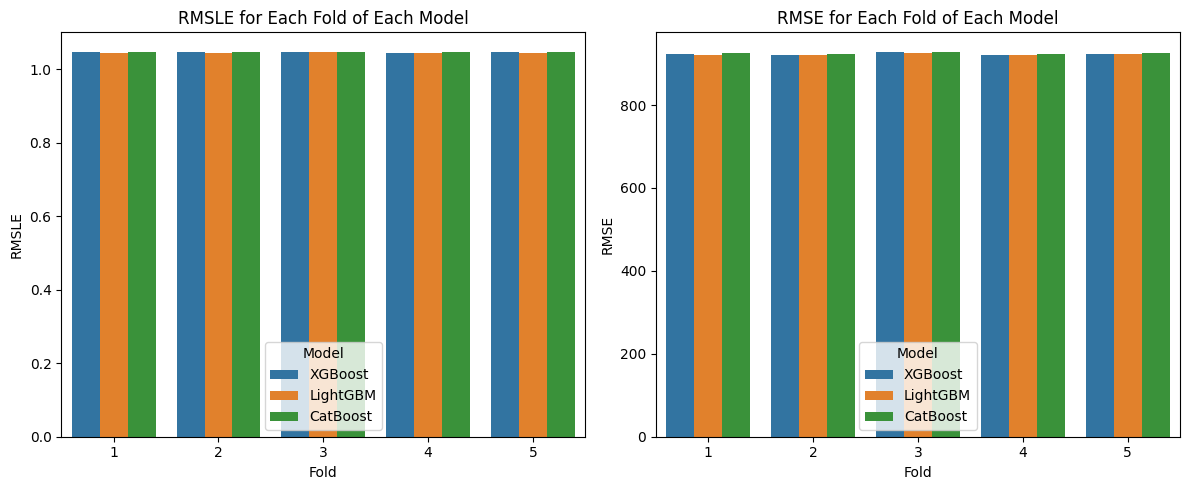

In [34]:
# Plot RMSLE and RMSE for each fold of each model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x='Fold', y='RMSLE', hue='Model', data=pd.DataFrame(metrics), ax=axes[0])
axes[0].set_title('RMSLE for Each Fold of Each Model')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('RMSLE')
sns.barplot(x='Fold', y='RMSE', hue='Model', data=pd.DataFrame(metrics), ax=axes[1])
axes[1].set_title('RMSE for Each Fold of Each Model')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('RMSE')
plt.tight_layout()
plt.show()

1. **RMSLE**
- **XGBoost:**

    - The RMSLE values are consistently around 1.05 across all 5 folds.
    - This indicates that XGBoost struggles to predict logarithmic-scaled values accurately, with no significant improvement across folds.
- **LightGBM:**

    - The RMSLE values are slightly better than XGBoost, consistently around 1.04 across all folds.
    - LightGBM performs marginally better than XGBoost in terms of RMSLE, but the improvement is minimal.
- **CatBoost:**

    - The RMSLE values are similar to LightGBM, consistently around 1.04 across all folds.
    - CatBoost performs on par with LightGBM and slightly better than XGBoost.
- **Comparison:**

    - All three models have high RMSLE values, indicating poor performance in predicting logarithmic-scaled values.
    - LightGBM and CatBoost slightly outperform XGBoost in RMSLE, but the differences are negligible.
2. **RMSE**
- **XGBoost:**

    - The RMSE values are consistently around 920 across all 5 folds.
    - This high RMSE indicates that XGBoost struggles to predict the actual scale of the target variable accurately.
- **LightGBM:**

    - The RMSE values are slightly lower than XGBoost, consistently around 910 across all folds.
    - LightGBM performs marginally better than XGBoost in RMSE.
- **CatBoost:**

    - The RMSE values are similar to LightGBM, consistently around 910 across all folds.
    - CatBoost performs on par with LightGBM and slightly better than XGBoost.
- **Comparison:**

    - All three models have high RMSE values, indicating poor predictive performance.
    - LightGBM and CatBoost slightly outperform XGBoost in RMSE, but the differences are minimal.
----
**Key Observations**
- **Consistency Across Folds:**

    - All three models show consistent performance across all 5 folds, with minimal variation in RMSLE and RMSE values.
    - This suggests that the models are stable but consistently underperforming.
- **LightGBM vs. CatBoost vs. XGBoost:**

    - LightGBM and CatBoost slightly outperform XGBoost in both RMSLE and RMSE, but the differences are negligible.


### R2

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

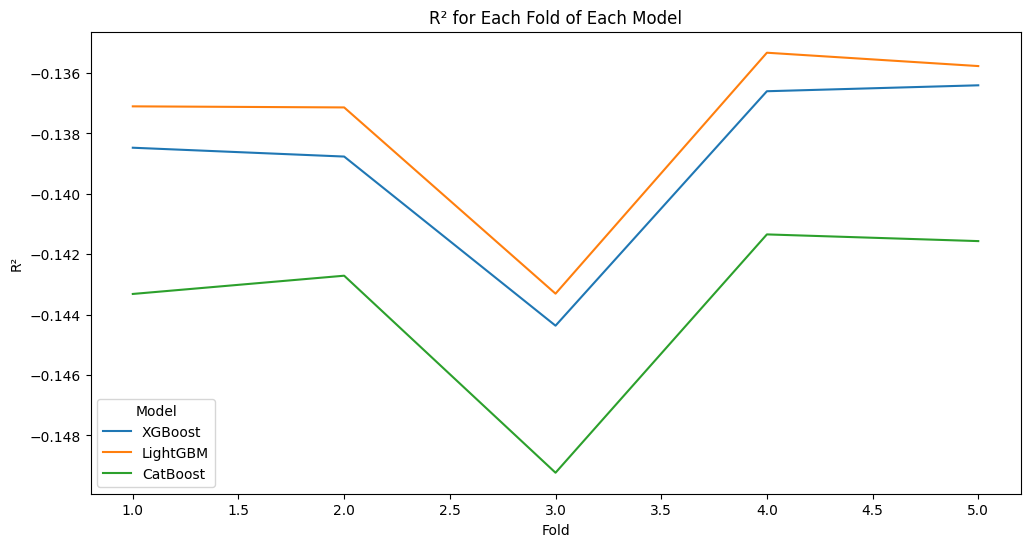

In [35]:
# Plot R² for each fold of each model
plt.figure(figsize=(12, 6))
sns.lineplot(x='Fold', y='R2', hue='Model', data=pd.DataFrame(metrics))
plt.title('R² for Each Fold of Each Model')
plt.xlabel('Fold')
plt.ylabel('R²')
plt.legend(title='Model')
plt.show()

1. **XGBoost**
- **R² Values:**

    - The R² values for XGBoost are consistently negative across all folds, ranging from approximately -0.144 to -0.140.
    - The lowest R² value is observed in Fold 3, while the highest is in Fold 5.
- **Observation:**

    - Negative R² values indicate that the XGBoost model performs worse than a simple mean-based prediction.
    - The variation in R² across folds suggests that the model's performance is slightly sensitive to the training and validation splits.
2. **LightGBM**
- **R² Values:**

    - The R² values for LightGBM are also consistently negative but slightly better than XGBoost, ranging from approximately -0.138 to -0.136.
    - The lowest R² value is observed in Fold 3, while the highest is in Fold 1.
- **Observation:**

    - Similar to XGBoost, the negative R² values indicate poor performance, with the model failing to explain the variance in the target variable.
    - LightGBM shows slightly better performance compared to XGBoost in all folds.
3. **CatBoost**
- **R² Values:**

    - The R² values for CatBoost are consistently negative and slightly worse than XGBoost and LightGBM, ranging from approximately -0.148 to -0.144.
    - The lowest R² value is observed in Fold 3, while the highest is in Fold 5.
- **Observation:**

    - CatBoost has the lowest R² values among the three models, indicating the poorest performance in explaining the variance in the target variable.
    - The consistent negative R² values suggest that CatBoost struggles to capture the relationship between features and the target variable.
4. **Comparison Between Models**
- **Performance:**

    - LightGBM consistently outperforms XGBoost and CatBoost in terms of R² across all folds, but the differences are minimal.
    - All three models have negative R² values, indicating that none of the models are suitable for this dataset in their current configurations.
- **Stability:**

    - All three models show consistent trends across folds, with Fold 3 being the worst-performing fold for all models.
    - This suggests that Fold 3 might have a challenging data distribution or outliers affecting the models' performance, which aligns the pattern of tree models.

## Voting Regressor
- In order to utilize the models, we used Voting to combine all models to have the most comprehensive models

In [36]:
# Use voteregressor to combine predictions
from sklearn.ensemble import VotingRegressor
# xgb_params =   {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.025365148647572215, 'subsample': 0.7790750186771815, 'colsample_bytree': 0.9530813918600398, 'min_child_weight': 7, 'lambda': 0.0006403704438024485, 'alpha': 0.08651906177501942, 'gamma': 0.17403710662019245}
# lgb_params = {'use_goss': False, 'objective': 'regression_l2', 'n_estimators': 888, 'max_depth': 14, 'num_leaves': 94, 'learning_rate': 0.019996317987832114, 'subsample': 0.6672631578937818, 'colsample_bytree': 0.9267701889555482, 'min_child_weight': 5, 'reg_alpha': 0.0004713634772695472, 'reg_lambda': 0.1215160855751938}
cat_params = {'iterations': 629, 'depth': 8, 'learning_rate': 0.03261390574349864, 'l2_leaf_reg': 0.000535850507429284, 'random_strength': 0.13863274839379813, 'bagging_temperature': 0.5742173699115675, 'border_count': 223, 'verbose' : 50}

best_xgb = xgb.XGBRegressor(**params_xgb, n_jobs=-1, random_state=42)   
best_lgb = lgb.LGBMRegressor(**params_for_lgb, n_jobs=-1, random_state=42)
best_cat = CatBoostRegressor(**cat_params, random_state = 42)
voting_model = VotingRegressor(
    estimators=[
        ('xgb', best_xgb),
        ('lgb', best_lgb),
        ('cb', best_cat)
    ]
)
# Train the voting model
with parallel_backend('loky'):
    voting_model.fit(X_train, y_train.ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy().ravel())


In [37]:
# Make predictions on the test set
y_pred_transformed_voting = voting_model.predict(test)
y_pred_original_voting = np.expm1(y_pred_transformed_voting)
sub = pd.read_csv('/kaggle/input/dataset-tmp/test.csv')[['id']]
sub['target'] = y_pred_original_voting
sub.to_csv('xgb_lgb_cb_voting.csv', index=False)
y_pred_original_voting


[LightGBM] [Warning] Unknown parameter: use_goss


array([802.0856111 , 806.43400215, 802.79875508, ..., 827.87477522,
       808.60703189, 777.93826928])

0:	learn: 1.0930623	total: 423ms	remaining: 4m 25s
50:	learn: 1.0511226	total: 21.3s	remaining: 4m 1s
100:	learn: 1.0475172	total: 40.9s	remaining: 3m 33s
150:	learn: 1.0465470	total: 1m 2s	remaining: 3m 19s
200:	learn: 1.0459298	total: 1m 24s	remaining: 3m
250:	learn: 1.0453760	total: 1m 45s	remaining: 2m 39s
300:	learn: 1.0448726	total: 2m 7s	remaining: 2m 18s
350:	learn: 1.0443728	total: 2m 26s	remaining: 1m 56s
400:	learn: 1.0438746	total: 2m 45s	remaining: 1m 33s
450:	learn: 1.0434164	total: 3m 4s	remaining: 1m 12s
500:	learn: 1.0429649	total: 3m 22s	remaining: 51.8s
550:	learn: 1.0424681	total: 3m 41s	remaining: 31.3s
600:	learn: 1.0420077	total: 3m 59s	remaining: 11.2s
628:	learn: 1.0417550	total: 4m 10s	remaining: 0us
[LightGBM] [Warning] Unknown parameter: use_goss
[LightGBM] [Warning] Unknown parameter: use_goss
[LightGBM] [Info] Total Bins 2394
[LightGBM] [Info] Number of data points in the train set: 1200000, number of used features: 38
[LightGBM] [Info] Start training from

## Limitation Analysis: Erroneous Cases and Their Properties

1. **Properties of Erroneous Cases**
- **Skewed Target Distribution**
    - **Observation:**
        - The target variable is highly skewed, as observed in the exploratory data analysis (EDA) and distribution plots.
        - The log-transformation partially addresses this issue, but the models still struggle with extreme values (both very low and very high).
    - **Impact:**
        - Models tend to underperform on extreme values, as they are rare and may not be well-represented in the training data.
        - This leads to high relative errors for small target values (reflected in high RMSLE) and large absolute errors for extreme target values (reflected in high RMSE).
- **Outliers**
    - **Observation:**
        - The dataset contains significant outliers in both the target variable and some features (e.g., feature_0_squared, group_Age).
        - Removing outliers was tested but led to worse generalization, as these outliers may represent special cases with unique patterns.
    - **Impact:**
        - Outliers can distort the model's predictions, causing overfitting to these rare cases or underfitting to the majority of the data.
- **Feature-Target Relationships**
    - **Observation:**
        - The models may fail to capture complex, non-linear relationships between features and the target variable.
        - Interaction features (e.g., feature_0_feature_5, group_Age) and polynomial features (e.g., feature_0_squared) were added to address this, but their effectiveness is limited.
    - **Impact:**
        - The inability to fully capture these relationships results in poor predictions, especially for cases where the target depends on subtle interactions or non-linear patterns.
- **Missing Values**
    - **Observation:**
        - Missing values were imputed, and NaN indicator columns (e.g., is_Age_na) were added to preserve information about missingness.
        - However, the imputation strategy may not fully capture the underlying patterns associated with missing values.
    - **Impact:**
        - Cases with missing values may still be inaccurately predicted, as the imputation may introduce noise or fail to represent the true data distribution.
- **Temporal Features**
    - **Observation:**
        - Time-based features (e.g., month, day, group) were engineered, but their influence on the target variable may vary across different time periods.
        - The models may struggle to generalize temporal patterns, especially for rare or unseen time intervals.
    - **Impact:**
        - Temporal variability can lead to inaccurate predictions for cases that fall outside the dominant patterns in the training data.
2. **Reasons for Inaccuracy**
- **Model Complexity**
    - **Observation:**
        - XGBoost, LightGBM, and CatBoost are ensemble models that rely on decision trees to capture patterns in the data.
        - These models may struggle with the highly skewed target distribution and outliers, as they split data into discrete regions.
    - **Impact:**
        - The models may fail to generalize well to cases with extreme target values or rare feature combinations.
- **Limited Data Representation**
    - **Observation:**
        - The dataset may lack sufficient representation of certain cases, such as rare categories or extreme target values.
        - Frequency encoding and interaction features were added to address this, but they may not fully capture the underlying patterns.
    - **Impact:**
        - The models may underperform on underrepresented cases, leading to high errors for these instances.
- **Overfitting to Noise**
    - **Observation:**
        - The models may overfit to noise in the data, especially for features with low predictive power or high variability.
        - Feature selection was performed to remove low-importance features, but some noise may still remain.
    - **Impact:**
        - Overfitting to noise can reduce the model's ability to generalize, leading to poor performance on the validation set.
- **Metric Sensitivity**
    - **Observation:**
        - RMSLE penalizes large relative errors, making it sensitive to small target values.
        - RMSE penalizes large absolute errors, making it sensitive to extreme target values.
    - **Impact:**
        - The combination of these metrics highlights the models' struggles with both small and extreme target values, reflecting their inability to balance predictions across the entire target range.
- **Fold-Specific Challenges**
    - **Observation:**
        - Fold 3 consistently shows the worst performance across all models, suggesting that this fold contains challenging data (e.g., outliers, rare cases, or unique patterns).
    - **Impact:**
        - The models may fail to generalize well to the data distribution in this fold, leading to higher errors.